In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datasets import load_dataset

In [11]:
dataset = "ultra"
method = "st"
score = "highvar"
if method == "st":
    file_path = f"../split/{dataset}/{dataset}_full_{score}.jsonl"
else:
    file_path = f"../split/{dataset}/{method}/{dataset}_{method}_{score}.jsonl"
cfg = {
    "title": f"{dataset}_{method}_{first}_{score}",
}
print(cfg["title"])

ultra_st_highavg_highvar


In [12]:
#data = load_dataset("json", data_files=file_path, split="train")

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../split/ultra/ultra_full_highvar.jsonl'

In [23]:
scores = []
gpt_scores = []

def sigmoid(x): return 1 / (1 + np.exp(-x))
                            
scores = [ item['scores'] for item in data]
scores_avg = [(np.mean(prob)) for prob in scores]
#scores_avg = [(gpt_scores[i]/np.mean(scores[i])) for i in range(len(data))]
score_variance = [item['score_variance'] for item in data]
correlation = [item['correlation'] for item in data]
instruction = [item['instruction'] for item in data]
gpt_inference = [item['gpt_inference'] for item in data]


response = []
for item in data:
    response_str = ""
    for i in range(len(item['completions'])):
        response_str += item['completions'][i]['response']
        if i != 3:
            response_str += ", "
    response.append(response_str)


combined_df = pd.DataFrame({
    'score_avg': scores_avg,
    'scores': scores,
    'score_variance': score_variance,
    'correlation': correlation,
    'response': response,
    'instruction': instruction,
    'gpt_inference': gpt_inference
})



The minimum cosine similarity in the filtered dataframe is: -0.8386845962774606


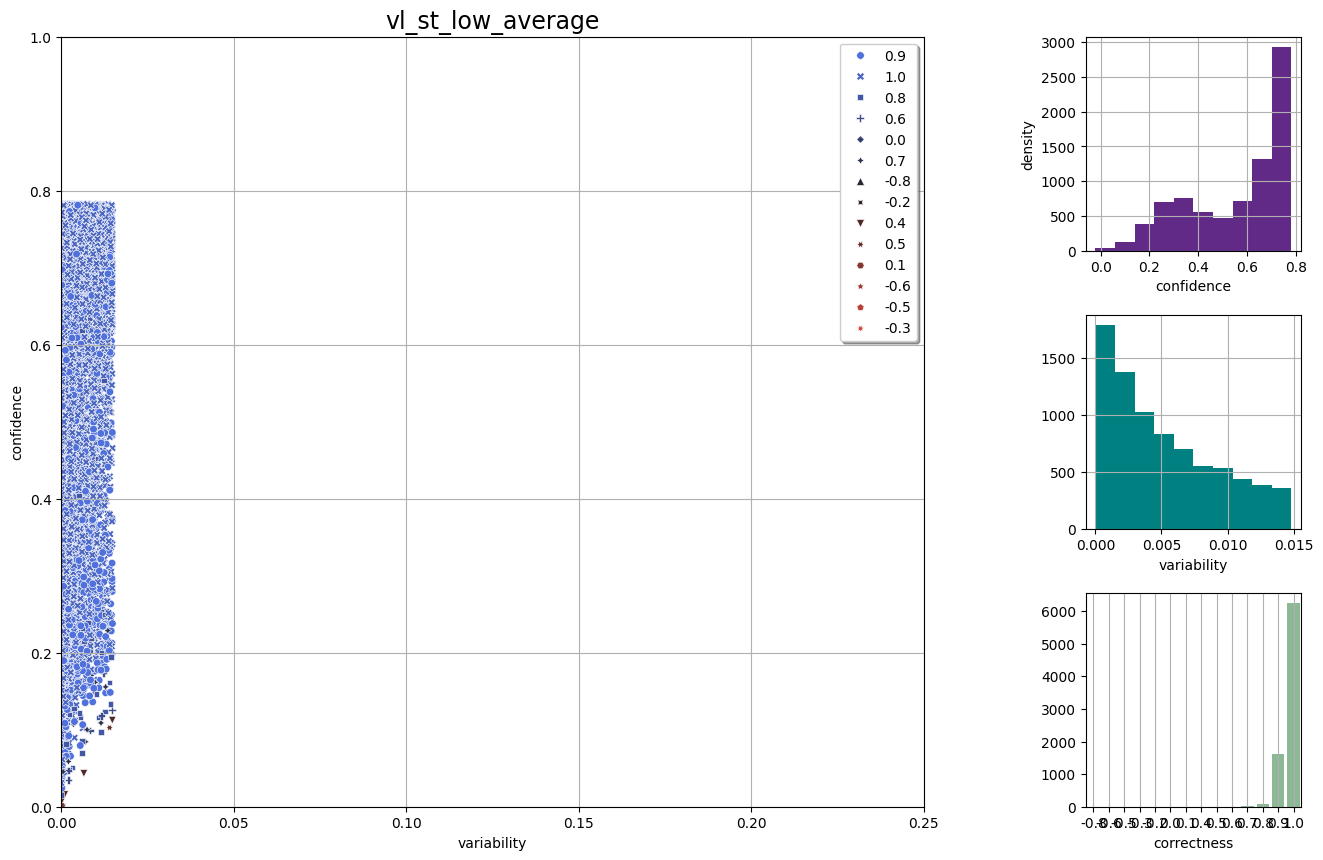

In [24]:
def scatter_it(dataframe, hue_metric ='correct.', title='', model='Cosine', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correlation / d.correlation.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['correlation']]
    
    main_metric = 'score_variance'
    other_metric = 'score_avg'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
        ax0.grid(True)
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])  
        ax0 = fig.add_subplot(gs[0, 0]) 
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
        ax0.set_xlim(0.0, 0.25)  # Set x-axis limits to [0, 1]
        ax0.grid(True)
    
    
    ### Make the scatterplot.

    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    # bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    # an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", rotation=350, bbox=bb('black'))
    # an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", bbox=bb('r'))
    # an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
    #              va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{cfg['title']}", fontsize=17)
        
        # Make the histograms.
        right_gs = gs[0, 1].subgridspec(3, 1, height_ratios=[1, 1, 1])  
        ax1 = fig.add_subplot(right_gs[0, 0])
        ax2 = fig.add_subplot(right_gs[1, 0])  
        ax3 = fig.add_subplot(right_gs[2, 0]) 

        plott0 = dataframe.hist(column=['score_avg'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['score_variance'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')
        sorted_order = sorted(dataframe['correct.'].unique(), key=lambda x: float(x))


        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3, order=sorted_order)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    # fig.tight_layout()
    # filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    # fig.savefig(filename, dpi=300)

correlation_min_max = [(-1, 1)]

for min_max in correlation_min_max:
    filtered_df = combined_df[combined_df['correlation'] > min_max[0]]
    filtered_df = filtered_df[filtered_df['correlation'] < min_max[1]]
    min_correlation = filtered_df['correlation'].min()
    print(f"The minimum cosine similarity in the filtered dataframe is: {min_correlation}")
    scatter_it(filtered_df, title='Proxy-Response', show_hist=True)

In [65]:
file_path = "/home/eunwon/Dataset-Cartography-for-Alignment/src/split/lowavg.jsonl"
dataset = "ultra"
method = "st"
first = "lowavg" 

cfg = {
    "title": f"{dataset}_{method}_{first}",
}

def load_processed_data(open_json):
    with open(open_json, 'r') as file:
        data = [json.loads(line) for line in file.readlines()]
    return data

#data = load_processed_data(file_path)

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [66]:
scores = []
gpt_scores = []

def sigmoid(x): return 1 / (1 + np.exp(-x))
                            
scores = [ item['scores'] for item in data]
scores_avg = [(np.mean(prob)) for prob in scores]
#scores_avg = [(gpt_scores[i]/np.mean(scores[i])) for i in range(len(data))]
score_variance = [item['score_variance'] for item in data]
correlation = [item['correlation'] for item in data]
instruction = [item['instruction'] for item in data]
gpt_inference = [item['gpt_inference'] for item in data]


response = []
for item in data:
    response_str = ""
    for i in range(len(item['completions'])):
        response_str += item['completions'][i]['response']
        if i != 3:
            response_str += ", "
    response.append(response_str)


combined_df = pd.DataFrame({
    'score_avg': scores_avg,
    'scores': scores,
    'score_variance': score_variance,
    'correlation': correlation,
    'response': response,
    'instruction': instruction,
    'gpt_inference': gpt_inference
})



/home/eunwon/.conda/envs/carto/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/eunwon/.conda/envs/carto/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


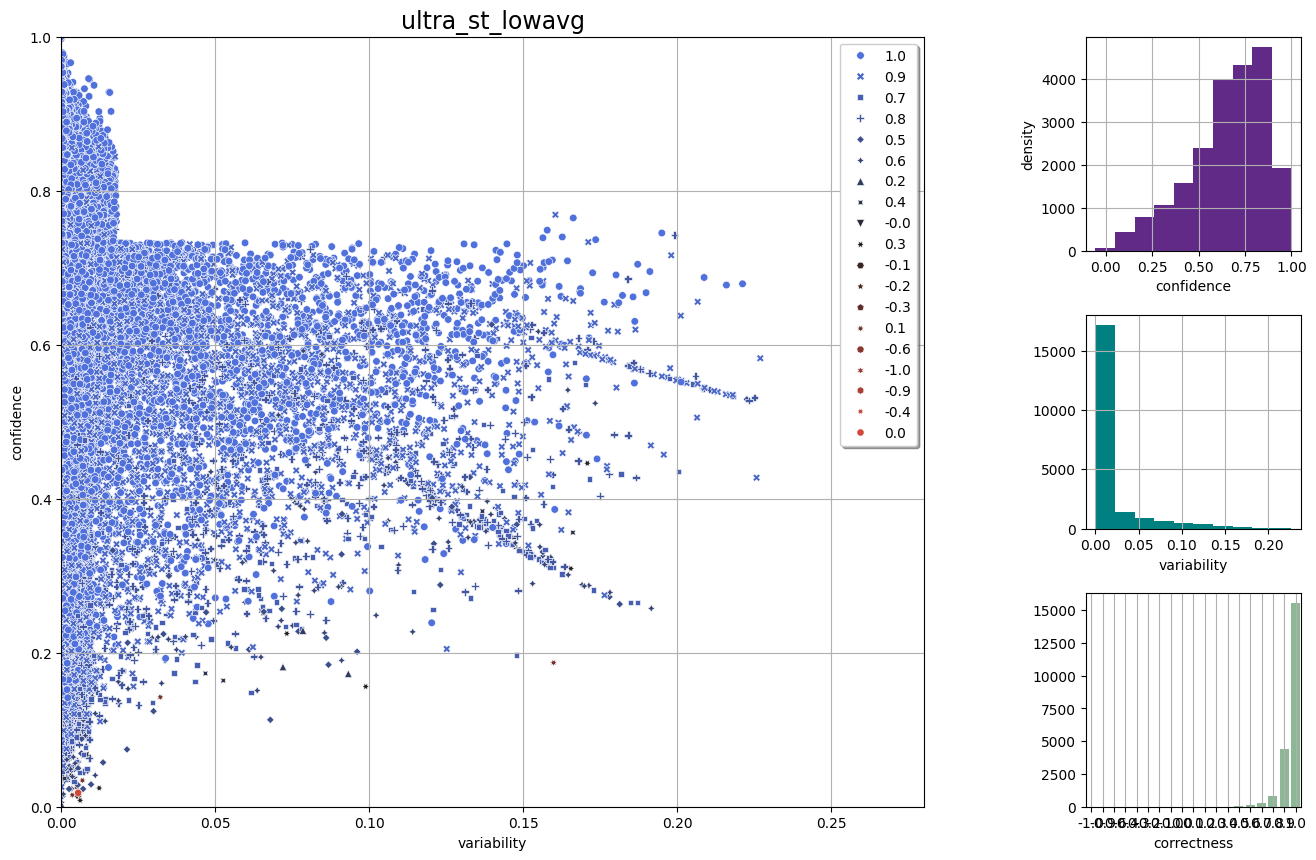

In [67]:
def scatter_it(dataframe, hue_metric='correct.', title='', model='Cosine', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac=lambda d: d.correlation / d.correlation.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['correlation']]
    
    main_metric = 'score_variance'
    other_metric = 'score_avg'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
        ax0.grid(True)
    else:
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])  
        ax0 = fig.add_subplot(gs[0, 0]) 
        ax0.set_ylim(0.0, 1.0)  # Set y-axis limits to [0, 1]
        ax0.set_xlim(0.0, 0.28)
        ax0.grid(True)
    
    # Compute percentiles for 33% and 66% for score_variance and score_avg
    # var_33, var_66 = dataframe['score_variance'].quantile([0.33, 0.66])
    # avg_33, avg_66 = dataframe['score_avg'].quantile([0.33, 0.66])

    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(
        x=main_metric, y=other_metric, ax=ax0, data=dataframe,
        hue=hue, palette=pal, style=style, s=30
    )

    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True, ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{title}", fontsize=17)

        # Make the histograms.
        right_gs = gs[0, 1].subgridspec(3, 1, height_ratios=[1, 1, 1])  
        ax1 = fig.add_subplot(right_gs[0, 0])
        ax2 = fig.add_subplot(right_gs[1, 0])  
        ax3 = fig.add_subplot(right_gs[2, 0]) 

        dataframe.hist(column=['score_avg'], ax=ax1, color='#622a87')
        ax1.set_title('')
        ax1.set_xlabel('confidence')
        ax1.set_ylabel('density')

        dataframe.hist(column=['score_variance'], ax=ax2, color='teal')
        ax2.set_title('')
        ax2.set_xlabel('variability')

        sorted_order = sorted(dataframe['correct.'].unique(), key=lambda x: float(x))
        sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3, order=sorted_order)
        ax3.xaxis.grid(True)  # Show the vertical gridlines
        ax3.set_title('')
        ax3.set_xlabel('correctness')
        ax3.set_ylabel('')

    plt.show()


correlation_min_max = [(-1, 1)]
for min_max in correlation_min_max:
    filtered_df = combined_df[combined_df['correlation'] > min_max[0]]
    filtered_df = filtered_df[filtered_df['correlation'] < min_max[1]]
    scatter_it(filtered_df, title=cfg['title'], show_hist=True)

In [12]:
import pandas as pd

# 33%, 66% 기준으로 나누기
var_33, var_66 = combined_df['score_variance'].quantile([0.33, 0.66])
avg_33, avg_66 = combined_df['score_avg'].quantile([0.33, 0.66])

# 각 데이터에 대해 구역 레이블 추가
def categorize_region(row):
    if row['score_variance'] < var_33:
        var_label = 'Low Variability'
    elif row['score_variance'] < var_66:
        var_label = 'Mid Variability'
    else:
        var_label = 'High Variability'

    if row['score_avg'] < avg_33:
        avg_label = 'Low Confidence'
    elif row['score_avg'] < avg_66:
        avg_label = 'Mid Confidence'
    else:
        avg_label = 'High Confidence'

    return f"{var_label} - {avg_label}"

combined_df['region'] = combined_df.apply(categorize_region, axis=1)

# 각 구역의 데이터 개수 확인 및 출력
region_counts = combined_df['region'].value_counts()

print(region_counts)


region
Low Variability - High Confidence     4679
High Variability - Low Confidence     4123
Mid Variability - Mid Confidence      2895
High Variability - Mid Confidence     2310
Mid Variability - Low Confidence      1812
Mid Variability - High Confidence     1754
Low Variability - Mid Confidence      1256
Low Variability - Low Confidence       526
High Variability - High Confidence     224
Name: count, dtype: int64
